In [102]:
import numpy as np
import matplotlib.pyplot as plt
import heapq
from typing import Union

In [103]:
%matplotlib inline
plt.style.use('default')

* `all_ns` -- все возможные значения для количества окошек в банке.
* `all_max_ks` -- все возможные значения длины очереди во втором эксперименте (в первом длина равна количеству окошек).
* `all_alphas` -- все возможные значения параметра в распределении.
* `total_count` -- количество раз, которое каждый эксперимент в конкретными параметрами будет запускаться.

In [104]:
all_ns = [500, 1000, 1500]
all_max_ks = list(map(lambda p: p * 3, all_ns))
all_alphas = [0.25, 0.5, 1, 2, 5]
total_count = 1000

In [105]:
current_legends = []

def plot_graph(xlabel: str, ylabel: str, title: str):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(current_legends)
    plt.show()
    current_legends.clear()

def add_to_plot(x: np.array, y: np.array, legend: Union[str, None]):
    plt.plot(x, y)
    if legend is not None:
        current_legends.append(legend)

Случай, в котором каждое окошко банка обрабатывает не больше двух человек.

Описание одного эксперимента:
* Генерируется `n` случайных экспоненциально распределенных времен.
* Сортируются по возрастанию -- именно в таком порядке люди из очереди будут подходить.

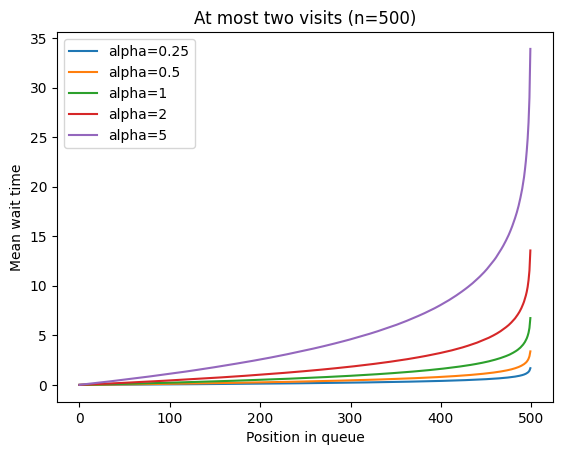

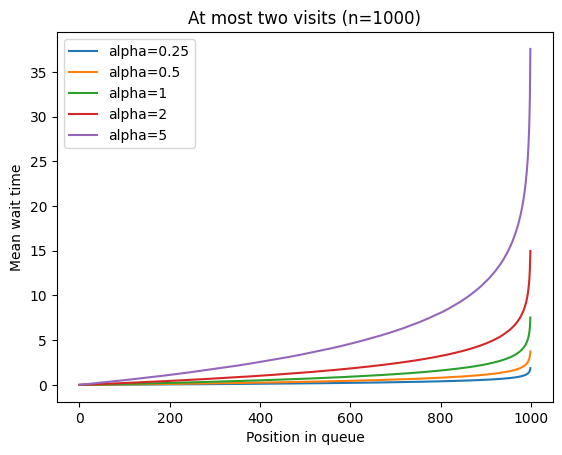

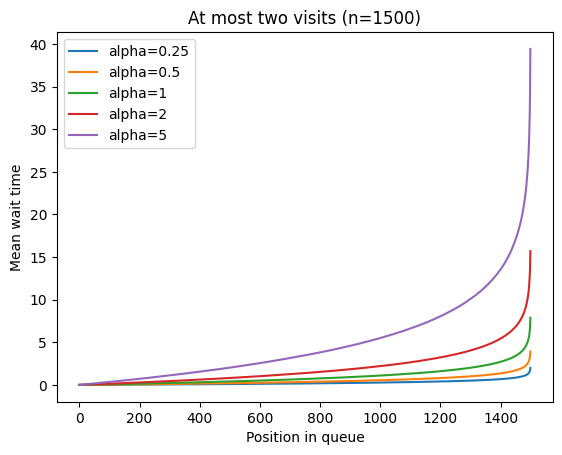

In [106]:
def make_experiment_2_at_most(n: int, alpha: float) -> np.array:
    return np.sort(np.random.exponential(alpha, n))

def make_experiments_2_at_most(n: int, alpha: float, count: int) -> np.array:
    result = np.zeros(n)
    for i in range(count):
        result += make_experiment_2_at_most(n, alpha)
    return result / count

def plot_experiments_2_at_most(ns: list, alphas: list, count: int):
    for n in ns:
        x = np.arange(n)
        for alpha in alphas:
            y = make_experiments_2_at_most(n, alpha, count)
            add_to_plot(x, y, "alpha={}".format(alpha))
        plot_graph("Position in queue", "Mean wait time", "At most two visits (n={})".format(n))

plot_experiments_2_at_most(all_ns, all_alphas, total_count)

## Результаты
Теоретически мы вывели формулу, что между двумя освободившимся окошками время распределенно $~Exp(\alpha (n - k))$.
Матожидание суммы -- это сумма матожиданий,
потому мы можем вычислить теоретическое значение матожидания для каждого человека в очереди.
Давайте сравним получившееся значение с ожидаемым и увидим, что различия в основном не очень большие.

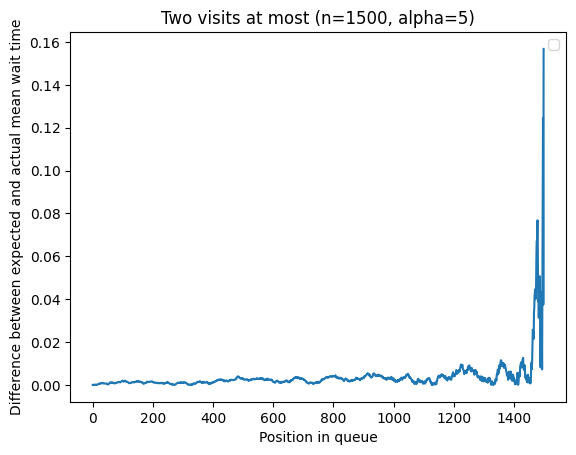

In [107]:
def plot_experiments_2_at_most_and_expected(n: int, alpha: float, count: int):
    x = np.arange(n)
    y1 = make_experiments_2_at_most(n, alpha, count)
    y2 = np.zeros(n)
    y2[0] = alpha / n
    for i in range(1, n):
        y2[i] = y2[i - 1] + alpha / (n - i)
    add_to_plot(x, np.abs(y1 - y2), None)
    plot_graph(
        "Position in queue",
        "Difference between expected and actual mean wait time",
        "Two visits at most (n={}, alpha={})".format(n, alpha)
    )

plot_experiments_2_at_most_and_expected(all_ns[-1], all_alphas[-1], total_count)

Случай, в котором каждое окошко может обрабатывать любое количество человек.

Описание одного эксперимента:
* Генерируем изначально `n` времен для изначального заполнения окошек и кладем их в кучу для оптимизации.
* Потом `max_k` раз достаем минимальный элемент из кучи `c` и добавляем в ответ.
* Генерируем новое значение `x` и кладем в кучу `c + x`.

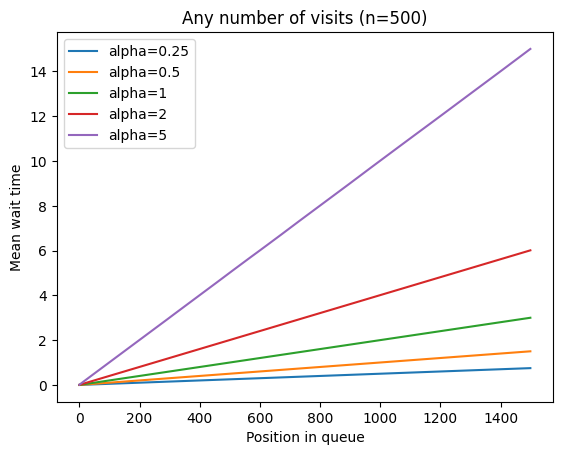

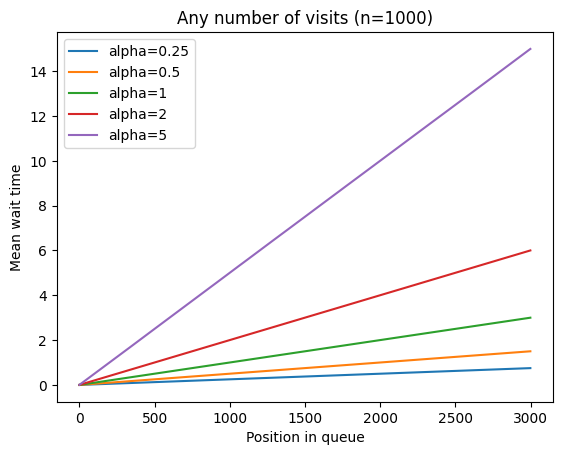

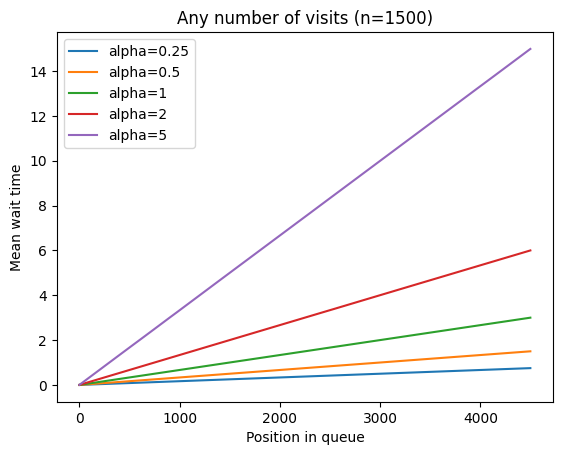

In [108]:
def make_experiment_any(n: int, max_k: int, alpha: float) -> np.array:
    times = list(np.sort(np.random.exponential(alpha, n)))
    heapq.heapify(times)
    result = np.zeros(max_k)
    for i in range(result.size):
        result[i] = heapq.heappop(times)
        heapq.heappush(times, np.random.exponential(alpha) + result[i])
    return result

def make_experiments_any(n: int, max_k: int, alpha: float, count: int) -> np.array:
    result = np.zeros(max_k)
    for i in range(count):
        result += make_experiment_any(n, max_k, alpha)
    return result / count

def plot_experiments_any(ns: list, max_ks: list, alphas: list, count: int):
    for n, max_k in zip(ns, max_ks):
        x = np.arange(max_k)
        for alpha in alphas:
            y = make_experiments_any(n, max_k, alpha, count)
            add_to_plot(x, y, "alpha={}".format(alpha))
        plot_graph("Position in queue", "Mean wait time", "Any number of visits (n={})".format(n))

plot_experiments_any(all_ns, all_max_ks, all_alphas, total_count)

## Результаты
Можно по данным вывести формулу $$\alpha \cdot k \, / \, n$$, где $$k$$ -- позиция в очереди.
Можно построить график разницы между полученной формулой и реальным результатом при определенных параметрах.
Заметим, что различия незначительные.

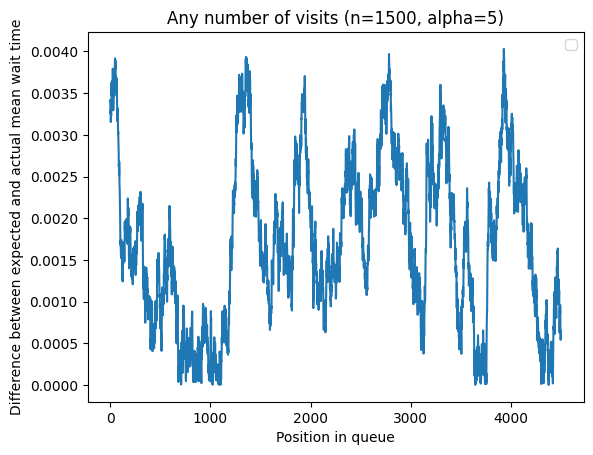

In [109]:
def plot_experiments_any_and_expected(n: int, max_k: int, alpha: float, count: int):
    x = np.arange(max_k)
    y1 = make_experiments_any(n, max_k, alpha, count)
    y2 = np.array([alpha * i / n for i in x])
    add_to_plot(x, np.abs(y1 - y2), None)
    plot_graph(
        "Position in queue",
        "Difference between expected and actual mean wait time",
        "Any number of visits (n={}, alpha={})".format(n, alpha)
    )

plot_experiments_any_and_expected(all_ns[-1], all_max_ks[-1], all_alphas[-1], total_count)